# (Technical) Illustrating Adding an Association Matrix to a Grouped Barplot

This assumes you worked your way through most of [the notebook 'Working with with Logan Search results in Jupyter'](Working_with_Logan_Search_results_with_Python_in_Jupyter.ipynb). If you hadn't, please go see it now.  
Importantly, while here the same input data is used and the top part of the plot looks the same as there, the additional details shown here is all 'mock' information.


#### This is adding 'mock' information in this case

I'm categorizing this notebook as 'technical' because the feature added to the plot is not based on actualy relevant data. It is just for illustrative purpose. The information it adds is completely invented. It is meant to illustrate with code how you could indicate such things on a plot figure. 
The idea is if you have actually bipligcally relevant data it may help you understand how to incorporate it in a plot figure. However, what is shown here isn't biologically relevant or even accurate.

We'll bring in the data like in [the notebook 'Working with with Logan Search results in Jupyter'](Working_with_Logan_Search_results_with_Python_in_Jupyter.ipynb) first by running the following cell.

In [1]:
results_dir = "/home/jovyan/logan_search_results/"
consistent_part_of_file_name_suffix = "_31mer_"

import os
import fnmatch
import pandas as pd

def extract_tags_from_filename(filename):
    '''
    extract tag labels from file names

    return the tag label
    '''
    first_part = filename.split(consistent_part_of_file_name_suffix,1)[0]
    all_but_first_part_of_remainder_as_list = first_part.split("_")[1:]
    return "_".join(all_but_first_part_of_remainder_as_list)
    
matched_filenames = []
file_tags_per_file = []
dfs = []
for file in os.listdir(results_dir):
    if fnmatch.fnmatch(file, '*.tsv'):
        matched_filenames.append(file)
        file_tags_per_file.append(extract_tags_from_filename(file))
        dfs.append(pd.read_csv(results_dir + file, sep="\t"))

# provide feedback about what was read in
max_filename_length = max(len(filename) for filename in matched_filenames)
for filename, df in zip(matched_filenames, dfs): 
    print(f'from {filename}:{" " * (max_filename_length - len(filename))} {len(df):>6} rows read in')

#print(file_tags_per_file) # FOR DEBUGGING, uncomment
#print(matched_filenames) # FOR DEBUGGING, uncomment
gene_name = file_tags_per_file[0].split("_",1)[0]
# make tuples of tag labels and corresponding dataframes
tags_and_dataframes = list(zip(file_tags_per_file, dfs)) # tags are first in each two-item tuple, the dataframe is second
# make dictionary of tuples of tag labels and corresponding dataframes, integers will be the keys with the tuples as values
tags_and_dataframes_dict = dict(zip(range(len(file_tags_per_file)), zip(file_tags_per_file, dfs))) # integers ('index') are keys with tags are first in each two-item tuple, the dataframe is second
print(f"\nTOTAL QUERY RESULTS READ IN: {len(file_tags_per_file)}")

from human_USP7_TSL4_altSJ_31mer_logan_results.tsv:  19997 rows read in
from human_USP7_TSL4_SJ_31mer_logan_results.tsv:     19998 rows read in
from human_USP7_SJ_14n15_31mer_logan_results.tsv:    19999 rows read in
from human_USP7_SJ_34_31mer_logan_results.tsv:       19997 rows read in

TOTAL QUERY RESULTS READ IN: 4


With that set-up step done, we are ready to run the code to produce **the mock figure**.

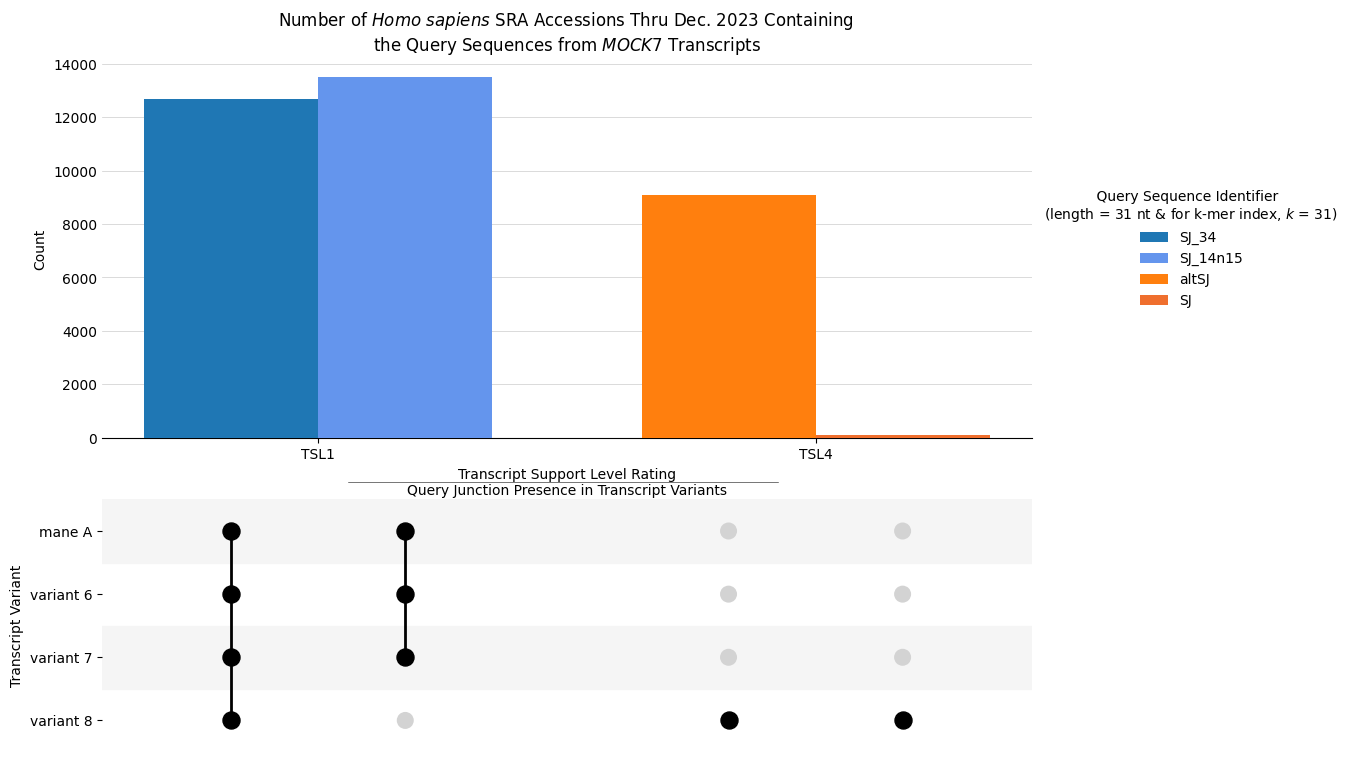

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

def simplifytags(tag):
    special_additional_name_part_to_not_include = "TSL4_"
    if special_additional_name_part_to_not_include in tag:
        new_tag = tag.split(special_additional_name_part_to_not_include,1)[1]
    else:
        new_tag = tag.split("_",1)[1]
    return new_tag

def plot_homo_sapiens_counts_with_association(dfs, labels=None, palette=None, order=None, gene_name="Gene?"
                                              ,variant_associations=None, variant_names=None):
    """
    Plot the count of 'Homo sapiens' in the 'organism' column with an UpSet-style
    association / combination matrix section below showing transcript variant associations.
    """
    # Calculate counts for each dataframe
    counts = [df['organism'].value_counts()['Homo sapiens'] if 'Homo sapiens' in df['organism'].values else 0 
             for df in dfs]

    # Categorize by Transcript Support Level (TSL) rating
    ratings = ['TSL1' if x.startswith('SJ_') else 'TSL4' for x in labels]

    # Use the provided labels or create default ones
    if labels is None:
        labels = [f'Dataset {i+1}' for i in range(len(dfs))]
    
    # Determine which labels are exonic and which are splice junctions
    all_exonic_queries = [label for label in labels if 'exon' in label.lower() or 
                     label in ['unique_5_prime_end', 'unique_to_5prime_of_A']]
    all_splice_junction_queries = [label for label in labels if label not in all_exonic_queries]
    
    # If order is provided, use it to sort the labels within their groups
    if order is not None:
        # Filter order to only include existing labels
        valid_order = [label for label in order if label in labels]
        
        # Create ordered groups based on the valid_order
        exonic_queries = [label for label in valid_order if label in all_exonic_queries]
        splice_junction_queries = [label for label in valid_order if label in all_splice_junction_queries]
        
        # Add any remaining labels not in the order
        for label in all_exonic_queries:
            if label not in exonic_queries:
                exonic_queries.append(label)
                
        for label in all_splice_junction_queries:
            if label not in splice_junction_queries:
                splice_junction_queries.append(label)
    else:
        exonic_queries = all_exonic_queries
        splice_junction_queries = all_splice_junction_queries
    
    # Combine the ordered lists to get the final display order
    ordered_labels = []
    for label in exonic_queries + splice_junction_queries:
        if label in labels and label not in ordered_labels:
            ordered_labels.append(label)
    
    
    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'Dataset': labels if labels else [f'Dataset {i+1}' for i in range(len(dfs))],
        'Count': counts,
        'Rating': ratings
    })

    # Create a figure with two subplots (barplot and association matrix)
    fig = plt.figure(figsize=(12, 9), facecolor='white')
    
    # Define the grid layout - top 60% for barplot, bottom 40% for association matrix
    #grid = plt.GridSpec(2, 1, height_ratios=[3, 2], hspace=0.1)
    grid = plt.GridSpec(2, 1, height_ratios=[3, 2], hspace=0.195) # need to adjust so moves down so what is displayed with `ax.set_xlabel()` shows
    
    # Create the main barplot axis
    ax = fig.add_subplot(grid[0])
    
    # Create the association matrix axis
    ax_matrix = fig.add_subplot(grid[1])
    
    # Prepare data for plotting
    #tsl_groups = ['TSL1', 'TSL4'] # would hardcode what I want as order
    #tsl_groups = list(set(ratings)) # gives same as what I would otherwise 
    # hardcode (I thought originally!!); the set step must order in some way or 
    # just 50-50 chance came out how I wanted?  ANSWER: Turns out just was 
    # chance. I started seeing it come out wrong! Make sure to add sort:
    tsl_groups = sorted(list(set(ratings))) 
    
    '''
    # Explicitly order the data
    tsl1_labels = [label for label in labels if label.startswith('SJ_')]
    tsl1_counts = [counts[labels.index(label)] for label in tsl1_labels]
    
    tsl4_labels = [label for label in labels if not label.startswith('SJ_')]
    tsl4_counts = [counts[labels.index(label)] for label in tsl4_labels]
    '''
    
    # Ensure SJ_34 is first in TSL1, and order matches original color assignment & desired_order
    tsl1_labels = order[:int(len(order)/2)]
    tsl1_counts = [counts[labels.index(tsl1_labels[0])], counts[labels.index(tsl1_labels[1])]]
    
    # Ensure order for TSL4 matches original color assignment & desired_order
    tsl4_labels = order[int(len(order)/2):]
    tsl4_counts = [counts[labels.index(tsl4_labels[0])], counts[labels.index(tsl4_labels[1])]]
    
    # Bar width and positions
    bar_width = 0.35
    bar_positions = []  # Store bar positions for aligning the matrix
    
    # Add grid BEFORE plotting bars
    ax.grid(axis='y', linestyle='-', linewidth=0.5, color='#cccccc', zorder=0)
    
    # Plot bars for TSL1 group
    ax.bar(0 - bar_width/2, tsl1_counts[0], bar_width, 
           label=tsl1_labels[0], color=palette[0], zorder=3)  # SJ_34
    bar_positions.append((tsl1_labels[0], 0 - bar_width/2))
    ax.bar(0 + bar_width/2, tsl1_counts[1], bar_width, 
           label=tsl1_labels[1], color=palette[1], zorder=3)  # SJ_14n15
    bar_positions.append((tsl1_labels[1], 0 + bar_width/2))
    
    # Plot bars for TSL4 group
    ax.bar(1 - bar_width/2, tsl4_counts[0], bar_width, 
           label=tsl4_labels[0], color=palette[2], zorder=3)  # altSJ
    bar_positions.append((tsl4_labels[0], 1 - bar_width/2))
    ax.bar(1 + bar_width/2, tsl4_counts[1], bar_width, 
           label=tsl4_labels[1], color=palette[3], zorder=3)  # SJ
    bar_positions.append((tsl4_labels[1], 1 + bar_width/2))
    
    # Customize the plot
    ax.set_xlabel('Transcript Support Level Rating\nQuery Junction Presence in Transcript Variants') # keeps x-axes labels consistent
    #ax.set_xlabel('Transcript Support Level Rating')
    
    ax.set_ylabel('Count')
    ax.set_title(('Number of $\mathit{Homo\ sapiens}$ SRA Accessions Thru Dec. 2023 Containing '
           '\nthe Query Sequences from $\mathit{' + gene_name + '}$ Transcripts'))
    
    # Set x-ticks exactly at the center of the groups
    ax.set_xticks([0, 1])
    ax.set_xticklabels(tsl_groups)
    
    # Despine the plot (remove top and right spines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Remove y-axis line
    ax.spines['left'].set_visible(False)
    
    # Remove y-axis ticks
    ax.tick_params(axis='y', length=0)
    
    # Create legend with no border and positioned to the right of the plot
    legend = ax.legend(title='            Query Sequence Identifier\n(length = 31 nt & for k-mer index, $\mathit{k}$ = 31)', 
                       loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    
    # Set the x-limits for both axes to ensure alignment
    x_min, x_max = ax.get_xlim()
    ax_matrix.set_xlim(x_min, x_max)

    # Create the association matrix part
    #-----------------------------------
    if variant_associations is None or variant_names is None:
        ax_matrix.text(0.5, 0.5, "No association data provided", 
                      horizontalalignment='center', verticalalignment='center')
    else:
        # Number of rows (variants) and columns (query types)
        n_variants = len(variant_names)
        n_queries = len(ordered_labels)
        
        # Create a matrix to store associations (1 if associated, 0 if not)
        matrix = np.zeros((n_variants, n_queries))
        
        # Fill the matrix
        for col_idx, label in enumerate(ordered_labels):
            if label in variant_associations:
                for var in variant_associations[label]:
                    if var in variant_names:
                        row_idx = variant_names.index(var)
                        matrix[row_idx, col_idx] = 1
        
        # Draw the matrix with dots and connections
        dot_size = 150
        
        # Create alternating row backgrounds for easier viewing
        for row_idx in range(n_variants):
            if row_idx % 2 == 0:
                # Make sure rectangle spans the full width
                ax_matrix.add_patch(Rectangle((x_min, row_idx-0.5), x_max-x_min, 1, 
                                            color='#f5f5f5', zorder=0))
        
        # Plot all dots (empty and filled)
        for row_idx in range(n_variants):
            for col_idx, (label, x_pos) in enumerate(bar_positions):
                # Find if this position has an association
                matrix_col_idx = ordered_labels.index(label)
                
                if matrix_col_idx < matrix.shape[1] and matrix[row_idx, matrix_col_idx] == 1:
                    # Filled dot
                    ax_matrix.scatter(x_pos, row_idx, s=dot_size, color='black', zorder=3)
                else:
                    # Empty dot
                    ax_matrix.scatter(x_pos, row_idx, s=dot_size, color='#d3d3d3', edgecolors='none', zorder=2)
        
        # Connect dots in the same column with vertical lines
        for col_idx, (label, x_pos) in enumerate(bar_positions):
            # Find all variants (rows) that have this feature
            matrix_col_idx = ordered_labels.index(label)
            filled_rows = []
            
            for row_idx in range(n_variants):
                if matrix_col_idx < matrix.shape[1] and matrix[row_idx, matrix_col_idx] == 1:
                    filled_rows.append(row_idx)
            
            # Draw vertical lines connecting dots if more than one variant has this feature
            if len(filled_rows) > 1:
                # Sort row indices for proper line drawing
                filled_rows.sort()
                # Draw lines connecting all filled dots in this column
                ax_matrix.plot([x_pos] * len(filled_rows), filled_rows, 
                              color='black', linewidth=2, zorder=1)
        
        # Set y-tick labels for variant names (using the provided order)
        ax_matrix.set_yticks(range(n_variants))
        ax_matrix.set_yticklabels(variant_names)

        #ax_matrix.set_title('Query Exon/Junction Presence in Transcript Variants') # putting it as part of the xlabel of above makes the both x-axes text look more consistent
        line = Line2D([0.33, 0.6888], [0.41, 0.41], transform=fig.transFigure, linewidth= 0.4, color='#0f0f0f') # want a line separating the x-axis labels for the two top & bottom panels of the plot figure
        fig.lines.append(line)
        
        # Remove x-ticks and labels (they're redundant with the barplot)
        ax_matrix.set_xticks([])
        
        # Set y-limits to show all variants with some padding
        ax_matrix.set_ylim(n_variants - 0.5, -0.5)  # Reversed to have variant A at top
        
        # Label the matrix
        ax_matrix.set_ylabel('Transcript Variant')

        # Remove the border around the matrix by hiding all spines
        ax_matrix.spines['top'].set_visible(False)
        ax_matrix.spines['right'].set_visible(False)
        ax_matrix.spines['bottom'].set_visible(False) # OPTIONAL, comment to leave this one in along the bottom
        ax_matrix.spines['left'].set_visible(False)
        #-------------------------------------------
        # END the create the association matrix part
        #-------------------------------------------
        
    
    
    # Adjust layout to make room for legend
    #plt.tight_layout() # Do I still need this here. I am seeing a warning 
    # `UserWarning: This figure includes Axes that are not compatible with
    # tight_layout, so results might be incorrect.`, when I use it for now AND
    # IMPORTANTLY THE LEGEND FOR TOP PART SEEMS FINE WITHOUT IT.   
    return fig

# Example usage:
labels = [simplifytags(x) for x in file_tags_per_file]
desired_order = [labels[3],labels[2],labels[0], labels[1]]  # Replace with your actual k-mer names in desired order
colors = ['#1f77b4', 'cornflowerblue', '#ff7f0e', '#ef6f2e']

# Define transcript variants
variant_names = ['mane A', 'variant 6', 'variant 7','variant 8']

# Define which variants are associated with each label
variant_associations = {
    'SJ_34': ['mane A', 'variant 6', 'variant 7','variant 8'],
    'SJ_14n15': ['mane A', 'variant 6', 'variant 7'],
    'SJ': ['variant 8'],
    'altSJ': ['variant 8'],
}
# Call the main function
plot = plot_homo_sapiens_counts_with_association(
    dfs, 
    labels, 
    palette=colors, 
    order=desired_order, 
    gene_name="MOCK7",
    variant_associations=variant_associations,
    variant_names=variant_names
)
plt.show()

Or handle the x-axis labels below each x-axis differently, like so....

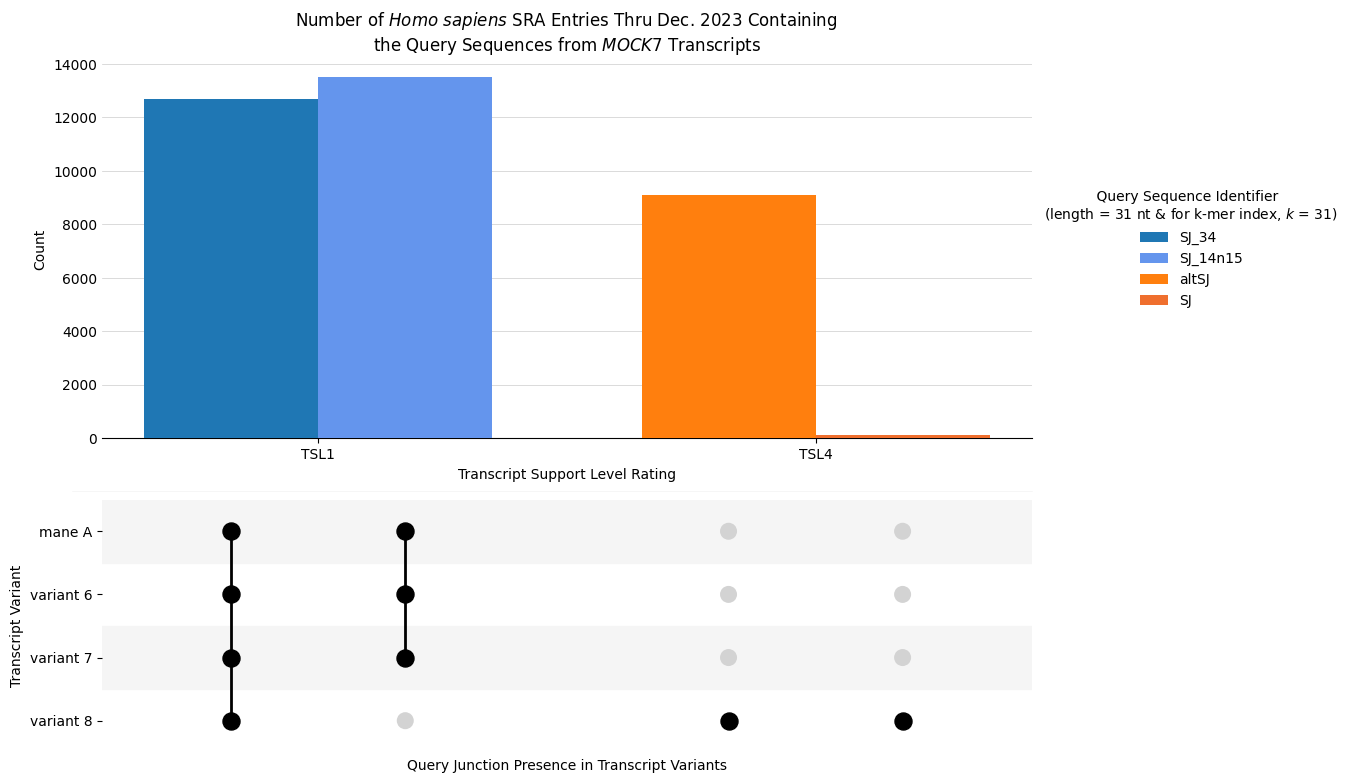

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

def simplifytags(tag):
    special_additional_name_part_to_not_include = "TSL4_"
    if special_additional_name_part_to_not_include in tag:
        new_tag = tag.split(special_additional_name_part_to_not_include,1)[1]
    else:
        new_tag = tag.split("_",1)[1]
    return new_tag

def plot_homo_sapiens_counts_with_association(dfs, labels=None, palette=None, order=None, gene_name="Gene?"
                                              ,variant_associations=None, variant_names=None):
    """
    Plot the count of 'Homo sapiens' in the 'organism' column with an UpSet-style
    association / combination matrix section below showing transcript variant associations.
    """
    # Calculate counts for each dataframe
    counts = [df['organism'].value_counts()['Homo sapiens'] if 'Homo sapiens' in df['organism'].values else 0 
             for df in dfs]

    # Categorize by Transcript Support Level (TSL) rating
    ratings = ['TSL1' if x.startswith('SJ_') else 'TSL4' for x in labels]

    # Use the provided labels or create default ones
    if labels is None:
        labels = [f'Dataset {i+1}' for i in range(len(dfs))]
    
    # Determine which labels are exonic and which are splice junctions
    all_exonic_queries = [label for label in labels if 'exon' in label.lower() or 
                     label in ['unique_5_prime_end', 'unique_to_5prime_of_A']]
    all_splice_junction_queries = [label for label in labels if label not in all_exonic_queries]
    
    # If order is provided, use it to sort the labels within their groups
    if order is not None:
        # Filter order to only include existing labels
        valid_order = [label for label in order if label in labels]
        
        # Create ordered groups based on the valid_order
        exonic_queries = [label for label in valid_order if label in all_exonic_queries]
        splice_junction_queries = [label for label in valid_order if label in all_splice_junction_queries]
        
        # Add any remaining labels not in the order
        for label in all_exonic_queries:
            if label not in exonic_queries:
                exonic_queries.append(label)
                
        for label in all_splice_junction_queries:
            if label not in splice_junction_queries:
                splice_junction_queries.append(label)
    else:
        exonic_queries = all_exonic_queries
        splice_junction_queries = all_splice_junction_queries
    
    # Combine the ordered lists to get the final display order
    ordered_labels = []
    for label in exonic_queries + splice_junction_queries:
        if label in labels and label not in ordered_labels:
            ordered_labels.append(label)
    
    
    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'Dataset': labels if labels else [f'Dataset {i+1}' for i in range(len(dfs))],
        'Count': counts,
        'Rating': ratings
    })

    # Create a figure with two subplots (barplot and association matrix)
    fig = plt.figure(figsize=(12, 9), facecolor='white')
    
    # Define the grid layout - top 60% for barplot, bottom 40% for association matrix
    #grid = plt.GridSpec(2, 1, height_ratios=[3, 2], hspace=0.1)
    grid = plt.GridSpec(2, 1, height_ratios=[3, 2], hspace=0.195) # need to adjust so moves down so what is displayed with `ax.set_xlabel()` shows
    
    # Create the main barplot axis
    ax = fig.add_subplot(grid[0])
    
    # Create the association matrix axis
    ax_matrix = fig.add_subplot(grid[1])
    
    # Prepare data for plotting
    #tsl_groups = ['TSL1', 'TSL4'] # would hardcode what I want as order
    #tsl_groups = list(set(ratings)) # gives same as what I would otherwise 
    # hardcode (I thought originally!!); the set step must order in some way or 
    # just 50-50 chance came out how I wanted?  ANSWER: Turns out just was 
    # chance. I started seeing it come out wrong! Make sure to add sort:
    tsl_groups = sorted(list(set(ratings))) 
    
    '''
    # Explicitly order the data
    tsl1_labels = [label for label in labels if label.startswith('SJ_')]
    tsl1_counts = [counts[labels.index(label)] for label in tsl1_labels]
    
    tsl4_labels = [label for label in labels if not label.startswith('SJ_')]
    tsl4_counts = [counts[labels.index(label)] for label in tsl4_labels]
    '''
    
    # Ensure SJ_34 is first in TSL1, and order matches original color assignment & desired_order
    tsl1_labels = order[:int(len(order)/2)]
    tsl1_counts = [counts[labels.index(tsl1_labels[0])], counts[labels.index(tsl1_labels[1])]]
    
    # Ensure order for TSL4 matches original color assignment & desired_order
    tsl4_labels = order[int(len(order)/2):]
    tsl4_counts = [counts[labels.index(tsl4_labels[0])], counts[labels.index(tsl4_labels[1])]]
    
    # Bar width and positions
    bar_width = 0.35
    bar_positions = []  # Store bar positions for aligning the matrix
    
    # Add grid BEFORE plotting bars
    ax.grid(axis='y', linestyle='-', linewidth=0.5, color='#cccccc', zorder=0)
    
    # Plot bars for TSL1 group
    ax.bar(0 - bar_width/2, tsl1_counts[0], bar_width, 
           label=tsl1_labels[0], color=palette[0], zorder=3)  # SJ_34
    bar_positions.append((tsl1_labels[0], 0 - bar_width/2))
    ax.bar(0 + bar_width/2, tsl1_counts[1], bar_width, 
           label=tsl1_labels[1], color=palette[1], zorder=3)  # SJ_14n15
    bar_positions.append((tsl1_labels[1], 0 + bar_width/2))
    
    # Plot bars for TSL4 group
    ax.bar(1 - bar_width/2, tsl4_counts[0], bar_width, 
           label=tsl4_labels[0], color=palette[2], zorder=3)  # altSJ
    bar_positions.append((tsl4_labels[0], 1 - bar_width/2))
    ax.bar(1 + bar_width/2, tsl4_counts[1], bar_width, 
           label=tsl4_labels[1], color=palette[3], zorder=3)  # SJ
    bar_positions.append((tsl4_labels[1], 1 + bar_width/2))
    
    # Customize the plot
    ax.set_xlabel('Transcript Support Level Rating\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nQuery Junction Presence in Transcript Variants') # this seems silly to have so many new lines; however, it 
    # helps keep the text styling consistent between the two titles
    #ax.set_xlabel('Transcript Support Level Rating')
    
    ax.set_ylabel('Count')
    ax.set_title(('Number of $\mathit{Homo\ sapiens}$ SRA Entries Thru Dec. 2023 Containing '
           '\nthe Query Sequences from $\mathit{' + gene_name + '}$ Transcripts'))
    
    # Set x-ticks exactly at the center of the groups
    ax.set_xticks([0, 1])
    ax.set_xticklabels(tsl_groups)
    
    # Despine the plot (remove top and right spines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Remove y-axis line
    ax.spines['left'].set_visible(False)
    
    # Remove y-axis ticks
    ax.tick_params(axis='y', length=0)
    
    # Create legend with no border and positioned to the right of the plot
    legend = ax.legend(title='            Query Sequence Identifier\n(length = 31 nt & for k-mer index, $\mathit{k}$ = 31)', 
                       loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    
    # Set the x-limits for both axes to ensure alignment
    x_min, x_max = ax.get_xlim()
    ax_matrix.set_xlim(x_min, x_max)

    # Create the association matrix part
    #-----------------------------------
    if variant_associations is None or variant_names is None:
        ax_matrix.text(0.5, 0.5, "No association data provided", 
                      horizontalalignment='center', verticalalignment='center')
    else:
        # Number of rows (variants) and columns (query types)
        n_variants = len(variant_names)
        n_queries = len(ordered_labels)
        
        # Create a matrix to store associations (1 if associated, 0 if not)
        matrix = np.zeros((n_variants, n_queries))
        
        # Fill the matrix
        for col_idx, label in enumerate(ordered_labels):
            if label in variant_associations:
                for var in variant_associations[label]:
                    if var in variant_names:
                        row_idx = variant_names.index(var)
                        matrix[row_idx, col_idx] = 1
        
        # Draw the matrix with dots and connections
        dot_size = 150
        
        # Create alternating row backgrounds for easier viewing
        for row_idx in range(n_variants):
            if row_idx % 2 == 0:
                # Make sure rectangle spans the full width
                ax_matrix.add_patch(Rectangle((x_min, row_idx-0.5), x_max-x_min, 1, 
                                            color='#f5f5f5', zorder=0))
        
        # Plot all dots (empty and filled)
        for row_idx in range(n_variants):
            for col_idx, (label, x_pos) in enumerate(bar_positions):
                # Find if this position has an association
                matrix_col_idx = ordered_labels.index(label)
                
                if matrix_col_idx < matrix.shape[1] and matrix[row_idx, matrix_col_idx] == 1:
                    # Filled dot
                    ax_matrix.scatter(x_pos, row_idx, s=dot_size, color='black', zorder=3)
                else:
                    # Empty dot
                    ax_matrix.scatter(x_pos, row_idx, s=dot_size, color='#d3d3d3', edgecolors='none', zorder=2)
        
        # Connect dots in the same column with vertical lines
        for col_idx, (label, x_pos) in enumerate(bar_positions):
            # Find all variants (rows) that have this feature
            matrix_col_idx = ordered_labels.index(label)
            filled_rows = []
            
            for row_idx in range(n_variants):
                if matrix_col_idx < matrix.shape[1] and matrix[row_idx, matrix_col_idx] == 1:
                    filled_rows.append(row_idx)
            
            # Draw vertical lines connecting dots if more than one variant has this feature
            if len(filled_rows) > 1:
                # Sort row indices for proper line drawing
                filled_rows.sort()
                # Draw lines connecting all filled dots in this column
                ax_matrix.plot([x_pos] * len(filled_rows), filled_rows, 
                              color='black', linewidth=2, zorder=1)
        
        # Set y-tick labels for variant names (using the provided order)
        ax_matrix.set_yticks(range(n_variants))
        ax_matrix.set_yticklabels(variant_names)

        # putting it as part of the xlabel of above makes the both x-axes text look more consistent
        line = Line2D([0.1, 0.90], [0.40, 0.40], transform=fig.transFigure, linewidth= 0.4, color='#efefef') # want a very subtle line separating the two top & bottom panels of the plot figure
        fig.lines.append(line)
        
        # Remove x-ticks and labels (they're redundant with the barplot)
        ax_matrix.set_xticks([])
        
        # Set y-limits to show all variants with some padding
        ax_matrix.set_ylim(n_variants - 0.5, -0.5)  # Reversed to have variant A at top
        
        # Label the matrix
        ax_matrix.set_ylabel('Transcript Variant')

        # Remove the border around the matrix by hiding all spines
        ax_matrix.spines['top'].set_visible(False)
        ax_matrix.spines['right'].set_visible(False)
        ax_matrix.spines['bottom'].set_visible(False) # OPTIONAL, comment to leave this one in along the bottom
        ax_matrix.spines['left'].set_visible(False)
        #-------------------------------------------
        # END the create the association matrix part
        #-------------------------------------------
        
    
    
    # Adjust layout to make room for legend
    #plt.tight_layout() # Do I still need this here. I am seeing a warning 
    # `UserWarning: This figure includes Axes that are not compatible with
    # tight_layout, so results might be incorrect.`, when I use it for now AND
    # IMPORTANTLY THE LEGEND FOR TOP PART SEEMS FINE WITHOUT IT.   
    return fig

# Example usage:
labels = [simplifytags(x) for x in file_tags_per_file]
desired_order = [labels[3],labels[2],labels[0], labels[1]]  # Replace with your actual k-mer names in desired order
colors = ['#1f77b4', 'cornflowerblue', '#ff7f0e', '#ef6f2e']

# Define transcript variants
variant_names = ['mane A', 'variant 6', 'variant 7','variant 8']

# Define which variants are associated with each label
variant_associations = {
    'SJ_34': ['mane A', 'variant 6', 'variant 7','variant 8'],
    'SJ_14n15': ['mane A', 'variant 6', 'variant 7'],
    'SJ': ['variant 8'],
    'altSJ': ['variant 8'],
}
# Call the main function
plot = plot_homo_sapiens_counts_with_association(
    dfs, 
    labels, 
    palette=colors, 
    order=desired_order, 
    gene_name="MOCK7",
    variant_associations=variant_associations,
    variant_names=variant_names
)
plt.show()

Please see the top of this notebook detailing that what is shown here isn't biologically relevant or even accurate.  
It is though meant to help you to add display of such information to relevant data by adapting the code.

-----

Enjoy!
